In [ ]:
import os
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend
import wandb
from wandb.keras import WandbCallback

In [ ]:
from encoders import EncoderResNet18, EncoderResNet34, EncoderResNet50, encoderCNN
from decoders import DecoderResNet18, DecoderResNet34, DecoderResNet50, decoderCNN
from datasets import data_loader
from embeddings import embedding
from reconstructions import reconstructions
from generations import Generations
from activations import VisualizeActivations
from gradcam import GradCam
from src.CVAE import CVAE

# import importlib
# importlib.reload(embeddings)
# from embeddings import embedding

backend.clear_session()

In [ ]:
# TO DO: this should be passed as arguments
dataset_name = 'cifar10'
model_name = 'CVAE_resnet'
kl_coefficient = .0
encoded_dim = 128
learning_rate = 0.0001 
epoch_count = 1
batch_size = 100
patience = 5

In [86]:
if dataset_name == 'experimental':
    #TO DO: move datasets in the repo and change root_folder

    train_ds, val_ds, input_shape, category_count, labels = data_loader(name=dataset_name, root_folder='/home/PERSONALE/nicolas.derus2/HistoDL/datasets/')
else:
    #TO DO: move datasets in the repo and change root_folder

    train_x, test_x, val_x, train_y, test_y, val_y, train_y_one_hot, test_y_one_hot, val_y_one_hot, input_shape, category_count, labels = data_loader(name=dataset_name,
                                                                                                                                        root_folder='/home/PERSONALE/nicolas.derus2/HistoDL/datasets/')

In [ ]:
train_x.shape[0] /41

In [ ]:

wandb.init(project="H-VAE", entity="nrderus",
  config = {
  "dataset": dataset_name,
  "model": model_name,
  "encoded_dim": encoded_dim,
  "kl_coefficient": kl_coefficient,
  "learning_rate": learning_rate,
  "epochs": epoch_count,
  "batch_size": batch_size,
  "patience": patience,
})

In [ ]:
if 'resnet' in model_name:
    encoder = EncoderResNet18(encoded_dim = encoded_dim)
    encoder = encoder.model(input_shape=(input_shape[0], input_shape[1], input_shape[2] + category_count))
else:
    encoder = encoderCNN(input_shape, category_count, encoded_dim, final_stride = 1 )

encoder.summary()

In [ ]:
if 'resnet' in model_name:
    decoder = DecoderResNet18( encoded_dim = encoded_dim, final_stride = 1)
    decoder = decoder.model(input_shape=(encoded_dim + category_count,))
else:
    decoder = decoderCNN(input_shape, category_count, encoded_dim)

decoder.summary()

In [ ]:
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    print("All devices: ", tf.config.list_logical_devices('TPU'))

    strategy = tf.distribute.experimental.TPUStrategy(resolver)
    with strategy.scope():
        cvae = CVAE(encoder, decoder, kl_coefficient, input_shape, category_count)
        cvae.built = True
        cvae_input = cvae.encoder.input[0]
        cvae_output = cvae.decoder.output
        mu = cvae.encoder.get_layer('mu').output
        log_var = cvae.encoder.get_layer('log_var').output

        opt = keras.optimizers.Adam(learning_rate = learning_rate)
        cvae.compile(optimizer = opt, run_eagerly=False)
except:
    cvae = CVAE(encoder, decoder, kl_coefficient, input_shape, category_count)
    cvae.built = True
    cvae_input = cvae.encoder.input[0]
    cvae_output = cvae.decoder.output
    mu = cvae.encoder.get_layer('mu').output
    log_var = cvae.encoder.get_layer('log_var').output


    opt = keras.optimizers.Adam(learning_rate = learning_rate)
    cvae.compile(optimizer = opt, run_eagerly=False)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
             patience=patience, restore_best_weights=False)

history = cvae.fit([train_x, train_y_one_hot],
                   validation_data = ([val_x, val_y_one_hot],None),
                   epochs = epoch_count,
                   batch_size = batch_size,
                   callbacks=[early_stop, WandbCallback(save_model = False) ]) #save_weights_only -> ValueError: Unable to create dataset (name already exists)

In [ ]:
_, input_label_train, train_input = cvae.conditional_input([train_x[:1000], train_y_one_hot[:1000]])
_, input_label_test, test_input = cvae.conditional_input([test_x[:1000], test_y_one_hot[:1000]])
_, input_label_val, val_input = cvae.conditional_input([val_x[:1000], val_y_one_hot[:1000]])

train_x_mean, train_log_var = cvae.encoder.predict(train_input)
test_x_mean, test_log_var = cvae.encoder.predict(test_input)
val_x_mean, val_log_var = cvae.encoder.predict(val_input)

In [ ]:
embedding(encoded_dim, category_count, train_x_mean, test_x_mean, val_x_mean, train_y, test_y, val_y, train_log_var, test_log_var, val_log_var, labels, quantity = 1000, avg_latent=True)

In [ ]:
reconstructions(cvae, train_x, train_y, train_x_mean, train_log_var, input_label_train, labels, set = 'train')

In [ ]:
reconstructions(cvae, test_x, test_y, test_x_mean, test_log_var, input_label_test, labels, set = 'test')

In [ ]:
generator = Generations(cvae, encoded_dim, category_count, input_shape, labels)
generator()

In [ ]:

activations_encoder = VisualizeActivations(cvae, cvae.encoder, test_x, test_y_one_hot)
activations_decoder = VisualizeActivations(cvae, cvae.decoder, test_x, test_y_one_hot)
activations_encoder()
activations_decoder()

In [ ]:
if 'resnet' in model_name:
    target_layer = "layer4"
else:
    target_layer = "block3_conv2"


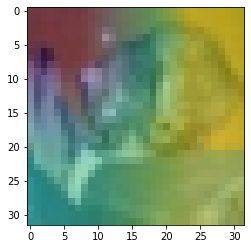

In [155]:
gc = GradCam(cvae, test_x, test_y_one_hot, HQ = True, target_layer = target_layer)
gc.gradcam()


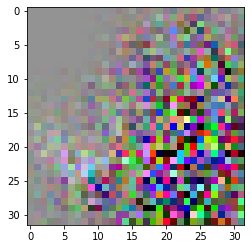

In [156]:
gc.guided_gradcam()

In [157]:
wandb.finish(exit_code=0, quiet = True) 